In [1]:
__version__ = "1.3.0" # data version of csv files

# library imports
import seaborn
import math
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean
from pathlib import Path
from csv import reader
from IPython.display import HTML, display
import tabulate
import seaborn as sns
import statsmodels.api as sm
from itertools import chain, product
from scipy.stats import poisson, skellam
import numpy as np



First things first, we need to set up some variables. headers for our games, and home_grounds so we know which team plays at home where.

In [2]:
headers = ['ball', 'innings', 'team', 'batsman', 'batsman_two', 'bowler', 'runs', 'extras', 'out', 'player_out']
home_grounds = {
    'Adelaide Strikers': 'Karen Rolton Oval',
    'Brisbane Heat': 'Allan Border Field',
    'Hobart Hurricanes': 'Bellerive Oval',
    'Melbourne Renegades': 'Junction Oval',
    'Melbourne Stars': 'Junction Oval',
    'Perth Scorchers': 'Lilac Hill Park',
    'Sydney Sixers': 'North Sydney Oval',
    'Sydney Thunder': 'Blacktown International Sportspark'
}

Now we need to load in the CSVs, which is pretty easy. We'll do a recursive glob over our repo folder to get all the CSVs into a list.

In [3]:
def iter_csvs():
    return list(Path('./data/').rglob('*.csv'))

local_csvs = iter_csvs()

Of course, now we need to actually load in the CSV files. Since the files have an info section and a balls section, we need to check which line we're working with and act accordingly. We'll store all the info as a dictionary for later access, and convert each ball into its own dictionary object and store it into a list of balls.

We'll also set a variable for determining what the latest season is, so that we have a test dataset.

In [4]:
def ingest_csv(csv_path_obj):
    with open(str(csv_path_obj), 'r') as fh:
        data = [l.split(',') for l in fh.read().split('\n') if l]
    info, balls = {}, []
    for line in data:
        if line[0] == 'version':
            assert line[1] == __version__
        elif line[0] == 'info':
            if line[1] in info.keys():
                info[f'{line[1]}_two'] = line[2]
            else:
                info[line[1]] = line[2]
        elif line[0] == 'ball':
            ball = dict(zip(headers, [l.replace('"', '') for l in line[1:]]))
            balls.append(ball)
    info['balls'] = balls
    return info

def ingest_csvs(csvs):
    return [ingest_csv(csv) for csv in csvs]

entire_data = ingest_csvs(local_csvs)
latest_season = sorted(list(set([e['season'].strip() for e in entire_data])))[-1]

Here we set up some empty lists so that we can do some iterative math. We want to know how many games each team played away and at home, what the runs scored and lost were, and what the wickets scored and lost were. We'll use these later to calculate strength of the teams, to inform the expected value.

In [5]:
teams = set([m['team'] for m in entire_data])
away_gamecount, home_gamecount = {t: 0 for t in teams}, {t: 0 for t in teams}
away_runs, home_runs = {t: [] for t in teams}, {t: [] for t in teams}
away_runs_lost, home_runs_lost = {t: [] for t in teams}, {t: [] for t in teams}
away_wickets, home_wickets = {t: [] for t in teams}, {t: [] for t in teams}
away_wickets_lost, home_wickets_lost = {t: [] for t in teams}, {t: [] for t in teams}

Now we'll actually iterate over all the games. We'll ignore the latest season, since that's the test set. We'll store sums of runs and wickets into their respective lists, and increment a counter each time a team plays at home or away.

In [6]:
for game in entire_data:
    a, b = game['team'], game['team_two']
    v, s = game['venue'], game['season']
    if s != latest_season:

        runs = [
            sum([int(x['runs']) for x in game['balls'] if x['team']==a]),
            sum([int(x['runs']) for x in game['balls'] if x['team']==b])
        ]
        wickets = [
            sum([int(bool(x['player_out'])) for x in game['balls'] if x['team']==a]),
            sum([int(bool(x['player_out'])) for x in game['balls'] if x['team']==b])
        ]
        for t in [0,1]:
            team = [a,b][t]
            if v in home_grounds.get(team):
                home_runs[team].append(runs[t])
                home_runs_lost[team].append(runs[t-1])
                home_wickets[team].append(wickets[t])
                home_wickets_lost[team].append(wickets[t-1])
                home_gamecount[team] += 1
            elif v not in home_grounds.get(team):
                away_runs[team].append(runs[t])
                away_runs_lost[team].append(runs[t-1])
                away_wickets[team].append(wickets[t])
                away_wickets_lost[team].append(wickets[t-1])
                away_gamecount[team] += 1

Here we are going to calculate a bunch of means against all our arrays. We'll need these averages for when we calculate the strength ratios of teams later on.

In [7]:
def mean_dict(d):
    return {k: mean(v) for k, v in d.items()}
def mean_vals(d):
    return mean([v for k, v in d.items()])

home_league_run_avg = mean_vals(mean_dict(home_runs))
away_league_run_avg = mean_vals(mean_dict(away_runs))

home_league_run_lost_avg = mean_vals(mean_dict(home_runs_lost))
away_league_run_lost_avg = mean_vals(mean_dict(away_runs_lost))

home_league_wicket_avg = mean_vals(mean_dict(home_wickets))
away_league_wicket_avg = mean_vals(mean_dict(away_wickets))

home_league_wicket_lost_avg = mean_vals(mean_dict(home_wickets_lost))
away_league_wicket_lost_avg = mean_vals(mean_dict(away_wickets_lost))

away_league_run_avg, away_league_wicket_avg, home_league_run_avg, home_league_wicket_avg

(119.8375911137615, 6.064222000631661, 133.80416666666667, 5.2630952380952385)

Just to be sure, let's visually inspect and ensure that every team has played at home at least once.

In [8]:
home_gamecount, away_gamecount

({&#39;Melbourne Stars&#39;: 1,
  &#39;Perth Scorchers&#39;: 6,
  &#39;Adelaide Strikers&#39;: 3,
  &#39;Brisbane Heat&#39;: 5,
  &#39;Sydney Thunder&#39;: 2,
  &#39;Hobart Hurricanes&#39;: 12,
  &#39;Sydney Sixers&#39;: 7,
  &#39;Melbourne Renegades&#39;: 3},
 {&#39;Melbourne Stars&#39;: 41,
  &#39;Perth Scorchers&#39;: 36,
  &#39;Adelaide Strikers&#39;: 35,
  &#39;Brisbane Heat&#39;: 34,
  &#39;Sydney Thunder&#39;: 32,
  &#39;Hobart Hurricanes&#39;: 25,
  &#39;Sydney Sixers&#39;: 38,
  &#39;Melbourne Renegades&#39;: 34})

Here we are going to set up some functions for calculating strengths and weaknesses of each team. We predict the expected score of each team by measuring its score as a ratio of its game count and the league average. We do this for both home and away fielding and batting, and then cross-tabulate them later to get our predicted scores. We also set up a neutral scores function, in case both teams are playing away (which happens frequently)

In [9]:
def get_home_offence(t):
    return sum(home_runs[t]) / home_gamecount[t] / home_league_run_avg
def get_away_defence(a):
    return sum(away_runs_lost[a]) / away_gamecount[a] / away_league_run_lost_avg
def get_exp_home_runs(o, d):
    return o * d * home_league_run_avg
def get_away_offence(a):
    return sum(away_runs[a]) / away_gamecount[a] / away_league_run_avg
def get_home_defence(h):
    return sum(home_runs_lost[h]) / home_gamecount[h] / home_league_run_lost_avg

def get_predicted_scores(h, a):
    home_offence = get_home_offence(h)
    away_defence = get_away_defence(a)
    home_team_runs = home_offence * away_defence * home_league_run_avg

    away_offence = get_away_offence(a)
    home_defence = get_home_defence(h)
    away_team_runs = away_offence * home_defence * away_league_run_avg

    return home_team_runs, away_team_runs

def get_neutral_scores(h, a):
    home_offence = get_away_offence(h)
    away_defence = get_away_defence(a)
    home_team_runs = home_offence * away_defence * home_league_run_avg

    away_offence = get_away_offence(a)
    home_defence = get_away_defence(h)
    away_team_runs = away_offence * home_defence * away_league_run_avg

    return home_team_runs, away_team_runs

print(get_predicted_scores('Melbourne Stars', 'Hobart Hurricanes'))
print(get_predicted_scores('Hobart Hurricanes', 'Melbourne Stars'))
print(get_predicted_scores('Hobart Hurricanes', 'Brisbane Heat'))
print(get_predicted_scores('Brisbane Heat', 'Hobart Hurricanes'))
print(get_predicted_scores('Melbourne Stars', 'Brisbane Heat'))
print(get_predicted_scores('Brisbane Heat', 'Melbourne Stars'))

(165.38675688456115, 151.7863147683908)
(120.07817853998934, 118.95771400170426)
(123.55476410951954, 136.97453719947836)
(115.13462690809833, 108.86075823516437)
(155.85883990095726, 159.59185410254622)
(105.44870773134373, 99.40362594873395)


We repeat what we did above, but for wickets.

In [10]:
def get_home_wicket_offence(t):
    return sum(home_wickets[t]) / home_gamecount[t] / home_league_wicket_avg
def get_away_wicket_defence(a):
    return sum(away_wickets_lost[a]) / away_gamecount[a] / away_league_wicket_lost_avg
def get_exp_home_wickets(o, d):
    return o * d * home_league_wicket_avg
def get_away_offence_wicket(a):
    return sum(away_wickets[a]) / away_gamecount[a] / away_league_wicket_avg
def get_home_defence_wicket(h):
    return sum(home_wickets_lost[h]) / home_gamecount[h] / home_league_wicket_lost_avg

def get_predicted_wicket_scores(h, a):
    # runs scored at home / number home games / home league average
    home_offence = get_home_wicket_offence(h)
    away_defence = get_away_wicket_defence(a)
    home_team_wickets = home_offence * away_defence * home_league_wicket_avg

    away_offence = sum(away_wickets[a]) / away_gamecount[a] / away_league_wicket_avg
    home_defence = sum(home_wickets_lost[h]) / home_gamecount[h] / home_league_wicket_lost_avg
    away_team_wickets = away_offence * home_defence * away_league_wicket_avg

    return home_team_wickets, away_team_wickets

def get_neutral_wicket_scores(h, a):
    # runs scored at home / number home games / home league average
    home_offence = get_away_offence_wicket(h)
    away_defence = get_away_wicket_defence(a)
    home_team_wickets = home_offence * away_defence * home_league_wicket_avg

    away_offence = get_away_offence_wicket(a)
    home_defence = get_away_wicket_defence(h)
    away_team_wickets = away_offence * home_defence * away_league_wicket_avg

    return home_team_wickets, away_team_wickets

print(get_predicted_wicket_scores('Melbourne Stars', 'Hobart Hurricanes'))
print(get_predicted_wicket_scores('Hobart Hurricanes', 'Melbourne Stars'))
print(get_predicted_wicket_scores('Hobart Hurricanes', 'Brisbane Heat'))
print(get_predicted_wicket_scores('Brisbane Heat', 'Hobart Hurricanes'))
print(get_predicted_wicket_scores('Melbourne Stars', 'Brisbane Heat'))
print(get_predicted_wicket_scores('Brisbane Heat', 'Melbourne Stars'))

(2.6705460936529897, 8.13472048827854)
(5.952087543493637, 5.183448422083056)
(6.495490798063325, 5.051528726346968)
(5.519128593549511, 7.669879317519767)
(2.9979188298753807, 6.333259895718586)
(5.677375810717008, 6.127300224313104)


Time to calculate the poisson distribution. This will tell us the probability of our given events (knowing that the run of each ball is independent of every other ball over a given innings).
Note that it's really important to make sure we also account for neutral ground here, since that will inform our prediction.

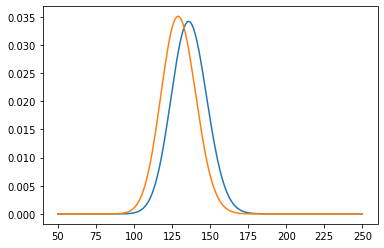

In [11]:
# if you don't want to shortcut on poisson, you can use this function:
def custom_poisson(actual, mean):
    return math.pow(mean, actual) * math.exp(-mean) / math.factorial(actual)


def make_poisson_dist(home, away, kind='scores'):
    if kind == 'scores':
        funct = get_predicted_scores
    elif kind == 'wickets':
        funct = get_predicted_wicket_scores
    elif kind == 'neutral scores':
        funct = get_neutral_scores
    elif kind == 'neutral wickets':
        funct = get_neutral_wicket_scores
    s_home, s_away = funct(home, away)
    if 'scores' in kind:
        t_home = list(range(50, 251))
        t_away = list(range(50, 251))
    elif 'wickets' in kind:
        t_home = list(range(0, 11))
        t_away = list(range(0, 11))
    p_home = poisson.pmf(t_home, s_home)
    p_away = poisson.pmf(t_away, s_away)
    prob_table = np.array([(i*j) for i, j in product(p_home, p_away)])
    prob_table.shape = (len(p_home), len(p_away))
    prob_df = pd.DataFrame(prob_table, index=t_home, columns=t_away)
    row, col = max(prob_df.idxmax(axis=0)), max(prob_df.idxmax(axis=1))
    probability = prob_df.loc[row,col] * 100
    return row, col, probability

home, away = 'Perth Scorchers', 'Brisbane Heat'
s_home, s_away = get_predicted_scores(home, away)

def plot_dists(s_home, s_away, min_: int=50, max_: int=251):
    t_home = list(range(min_, max_))
    p_home = poisson.pmf(t_home, s_home)
    plt.plot(t_home, p_home)
    t_away = list(range(min_, max_))
    p_away = poisson.pmf(t_away, s_away)
    plt.plot(t_away, p_away)
    plt.show()
    return t_home, p_home, t_away, p_away
t_home, p_home, t_away, p_away = plot_dists(s_home, s_away)

Also, let's create a tabular view so we can see what the most probable values are!

In [12]:
def make_density_table(home, p_home, t_home, away, p_away, t_away):
    headers = [f'{home}@home', 'indices', f'{away}@away', 'indices']
    test_list = pd.DataFrame(p_home, index=t_home)
    test_list2 = pd.DataFrame(p_away, index=t_away)
    bottom, top = test_list.loc[50], test_list.loc[250]
    bottom2, top2 = test_list2.loc[50], test_list2.loc[250]
    top10=test_list.sort_values(by=0, ascending=False)[0:10]
    top10_2=test_list2.sort_values(by=0, ascending=False)[0:10]
    full = pd.concat([bottom, top10, top])
    full['indices home'] = full.index
    full.reset_index(drop=True, inplace=True)
    full2 = pd.concat([bottom2, top10_2, top2])
    full2['indices away'] = full2.index
    full2.reset_index(drop=True, inplace=True)
    full3 = pd.concat([full, full2], axis=1)
    full3.reset_index(drop=True, inplace=True)
    return full3, headers

table, headers = make_density_table(home, p_home, t_home, away, p_away, t_away)
display(HTML(tabulate.tabulate(table, headers = headers, tablefmt='html')))

&lt;IPython.core.display.HTML object&gt;

Let's repeat the process, but swap the home ground and see what happens!

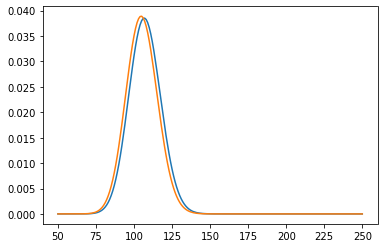

In [13]:
away, home = 'Perth Scorchers', 'Brisbane Heat'
s_home, s_away = get_predicted_scores(home, away)
t_home, p_home, t_away, p_away = plot_dists(s_home, s_away)

In [14]:
table, headers = make_density_table(home, p_home, t_home, away, p_away, t_away)
display(HTML(tabulate.tabulate(table, headers = headers, tablefmt='html')))

&lt;IPython.core.display.HTML object&gt;

We notice there are differences in home vs away, which is what we were looking for.

The next step is to create a probability matrix. This is achieved by multiplying the two Poisson distributions together. Although since there is a theoretical max score of 720 per innings, we'd expect that our probabilities themselves are quite small (e.g. 148 to 122 should produce a small number!).

We made the collective decision not to calculate for every possible run score, and so the matrix bottoms out at 50 and caps out at 250.

Also note that we can only use historical scores of the team and are limited by the youngness of the WBBL (as of this writing the WBBL has only hosted 210 matches, whereas the IPL has hosted 765). When each team has played hundreds of matches we can track the performance of each team much better (and end up with a much bigger matrix!)

In [15]:
prob_table = np.array([(i*j) for i, j in product(p_home, p_away)])
prob_table.shape = (len(p_home), len(p_away))
prob_df = pd.DataFrame(prob_table, index=t_home, columns=t_away)

cm = sns.light_palette("blue", as_cmap=True)

prob_df2=prob_df.style.background_gradient(cmap=cm)
display(prob_df2)


&lt;pandas.io.formats.style.Styler at 0x7ff852425310&gt;

Let's see if we can't figure out what our most probable run score is for this game.

In [16]:
row, col = max(prob_df.idxmax(axis=0)), max(prob_df.idxmax(axis=1))
probability = prob_df.loc[row,col] * 100
print(row, col, probability)

107 105 0.14986425717861065


As seen above, our suspicions were correct - matchups between teams are pretty even, and the odds of the score being a blowout are vanishingly small (at least in terms of the total runs scored, not accounting for technical wins e.g. wickets).

Our next step is to make a table of the offence and defence of each team, just to check that our math isn't way off.


In [17]:
table = [
    [t, get_home_offence(t), get_away_defence(t), get_away_offence(t), get_home_defence(t)]
    for t
    in teams
]

display(HTML(tabulate.tabulate(table, headers = ['Team Name', 'Home Offence', 'Away Defence', 'Away Offence', 'Home Defence'], tablefmt='html')))

&lt;IPython.core.display.HTML object&gt;

Really interestingly, the home field advantage seems to be all over the place. We suspect this is because some teams get to play disproportionately more games on their home fields than other teams.

This could also be due to the nature of the sport - where in cricket there are more fielders and only 2 batsmen.

We'll do the same table for wickets.

In [18]:
table = [
    [t, get_home_wicket_offence(t), get_away_wicket_defence(t), get_away_offence_wicket(t), get_home_defence_wicket(t)]
    for t
    in teams
]

display(HTML(tabulate.tabulate(table, headers = ['Team Name', 'Home Offence', 'Away Defence', 'Away Offence', 'Home Defence'], tablefmt='html')))

&lt;IPython.core.display.HTML object&gt;

Now it's time to actually calculate the predicted scores. We'll iterate over the last season of games and run a different calculation based on our assessment of which teams are playing at home. We'll append those to a final list that we'll use to verify against Pearson standardised residuals and density plots.

In [19]:
latest_season_games = [g for g in entire_data if g['season'] == latest_season]
result = []
for game in latest_season_games:
    temp = {}
    a, b, v = game['team'], game['team_two'], game['venue']

    temp[f'{a} runs'], temp[f'{b} runs'] = [
        sum([int(x['runs']) for x in game['balls'] if x['team']==a]),
        sum([int(x['runs']) for x in game['balls'] if x['team']==b])
    ]

    temp[f'{a} wickets'], temp[f'{b} wickets'] = [
        sum([int(bool(x['player_out'])) for x in game['balls'] if x['team']==a]),
        sum([int(bool(x['player_out'])) for x in game['balls'] if x['team']==b])
    ]

    # we need to check if both teams are not playing on home ground as this will affect the expected score
    both_away = not any([(v in home_grounds.get(a, '')), (v in home_grounds.get(b, ''))])
    if both_away:
        # if both teams are away, get away calculations 
        _home_runs, _away_runs, _runs_prob = make_poisson_dist(a, b, kind='neutral scores')
        _home_wickets, _away_wickets, _wickets_prob = make_poisson_dist(a, b, kind='neutral wickets')
    elif v in home_grounds.get(a, ''):
        # otherwise if a is home, put a first
        _home_runs, _away_runs, _runs_prob = make_poisson_dist(a, b, kind='scores')
        _home_wickets, _away_wickets, _wickets_prob = make_poisson_dist(a, b, kind='wickets')
    elif v in home_grounds.get(b, ''):
        # but if b is home, swap the variables over
        _away_runs, _home_runs, _runs_prob = make_poisson_dist(b, a, kind='scores')
        _away_wickets, _home_wickets, _wickets_prob = make_poisson_dist(b, a, kind='wickets')
    temp[f'{a} runs pred'] = _home_runs
    temp[f'{b} runs pred'] = _away_runs
    temp['runs %'] = _runs_prob
    temp[f'{a} wickets pred'] = _home_wickets
    temp[f'{b} wickets pred'] = _away_wickets
    temp['wickets %'] = _wickets_prob
    result.append(temp)


for res in result[0:5]:
    table = [list(res.values())]
    headers = list(res.keys())
    display(HTML(tabulate.tabulate(table, headers = headers, tablefmt='html')))


&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

Now it is time to calculate the standardised residuals. Statsmodels makes this pretty easy. We'll join all the observed values into one list and place them in a contigency table with the expected values.

In [20]:
# For posterity's sake, if you didn't want to use statsmodels, you can use these functions below.
def residuals(observed, expected):
    return (observed - expected) / np.sqrt(expected)

def standardised_residuals(observed, expected):
    n = observed.sum()
    r_sum, c_sum = margins(observed)
    r_sum = r_sum.astype(np.float64)
    c_sum = c_sum.astype(np.float64)
    v = c_sum * r_sum * (n - r_sum) * (n - c_sum) / n**3
    return (observed - expected) / np.sqrt(v)

#For runs of both teams, wickets of both teams, calculate the residuals...
residuals = {
    'runs': sm.stats.Table(np.array([[list(r.values())[0] for r in result]+[list(r.values())[1] for r in result], [list(r.values())[4] for r in result]+[list(r.values())[5] for r in result]])),
    'wickets': sm.stats.Table(np.array([[list(r.values())[2] for r in result]+[list(r.values())[3] for r in result], [list(r.values())[7] for r in result]+[list(r.values())[8] for r in result]])),
}

Now it's time to plot. We'll start with runs, and look at residuals vs fitted values (i.e. regression)

&lt;AxesSubplot:xlabel=&#39;Fitted Values&#39;, ylabel=&#39;S. Residuals&#39;&gt;

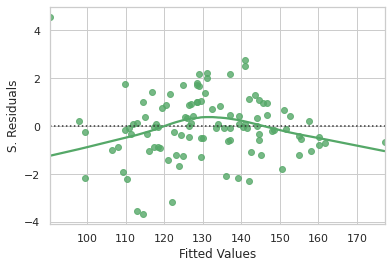

In [21]:
sns.set_theme(style="whitegrid")
fitted_values = pd.Series(residuals['runs'].fittedvalues[:1][0], name="Fitted Values")
s_residuals = pd.Series(residuals['runs'].resid_pearson[:1][0], name="S. Residuals")
sns.residplot(fitted_values, s_residuals, lowess=True, color="g")

Next let's see if there's an observable trend with the raw observations against the standardised residuals.

&lt;AxesSubplot:xlabel=&#39;Observed Values&#39;, ylabel=&#39;S. Residuals&#39;&gt;

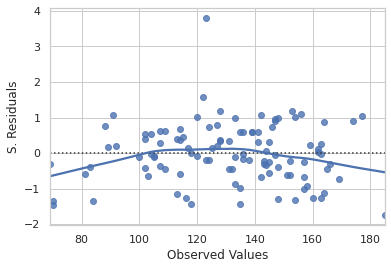

In [22]:

fitted_values = pd.Series(residuals['runs'].table[0], name="Observed Values")
s_residuals = pd.Series(residuals['runs'].resid_pearson[:1][0], name="S. Residuals")
sns.residplot(fitted_values, s_residuals, lowess=True, color="b")

Lastly, let's do a density plot to see if there's a skew towards over or underestimation.

&lt;AxesSubplot:ylabel=&#39;Density&#39;&gt;

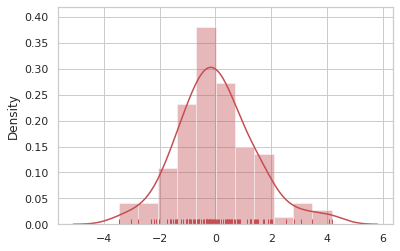

In [23]:
sns.distplot(residuals['runs'].resid_pearson[1:][0], color="r", rug=True)

Now let's repeat for wickets

&lt;AxesSubplot:xlabel=&#39;Fitted Values&#39;, ylabel=&#39;S. Residuals&#39;&gt;

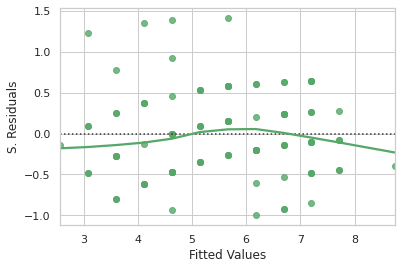

In [24]:
fitted_values = pd.Series(residuals['wickets'].fittedvalues[:1][0], name="Fitted Values")
s_residuals = pd.Series(residuals['wickets'].resid_pearson[:1][0], name="S. Residuals")
sns.residplot(fitted_values, s_residuals, lowess=True, color="g")

&lt;AxesSubplot:xlabel=&#39;Observed Values&#39;, ylabel=&#39;S. Residuals&#39;&gt;

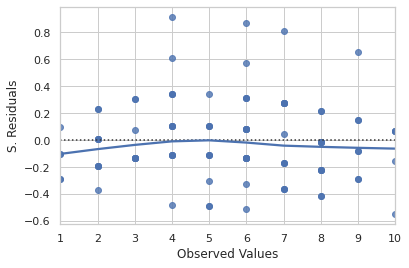

In [25]:

fitted_values = pd.Series(residuals['wickets'].table[0], name="Observed Values")
s_residuals = pd.Series(residuals['wickets'].resid_pearson[:1][0], name="S. Residuals")
sns.residplot(fitted_values, s_residuals, lowess=True, color="b")

&lt;AxesSubplot:ylabel=&#39;Density&#39;&gt;

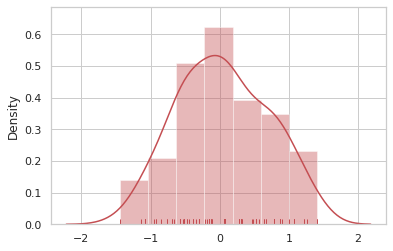

In [26]:
sns.distplot(residuals['wickets'].resid_pearson[1:][0], color="r", rug=True)